# [BERTによる類似文書の検索](https://lab.m-field.co.jp/2020/11/30/search-by-bert/)

## 変数設定

In [1]:
# clients = ["kosfja", "clb", "nu"]
# clients = ["clb"]
# clients = ["nu-chat", "sbd-chat", "ues-chat"]
clients = ["nu-chat"]

In [2]:
from_date = "2021-01-01"

In [3]:
to_date = "2021-03-31"
#to_date = "2021-01-31"

In [4]:
project_id = 'bwing-230309'

## Provide your credentials to the runtime

In [5]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Optional: Enable data table display

In [6]:
%load_ext google.colab.data_table

In [7]:
from google.cloud import bigquery

def query(project_id, client_id, from_date, to_date):
  client = bigquery.Client(project=project_id)

  print((project_id, client_id, from_date, to_date))
  
  df = client.query(f'''
  SELECT
    app_subdomain AS client,
    content AS text,
  FROM
    `bwing-230309.oksky_chat.content`
  WHERE
    app_subdomain = '{client_id}'
    AND date BETWEEN '{from_date}' AND '{to_date}'
    AND content != ''
    AND is_auto_message IS NOT TRUE
    AND is_customer IS TRUE
    AND regexp_extract(content, '(init|init_bot|テスト)') IS NULL
  ORDER BY timestamp
  ''').to_dataframe()
  # print(df.head(10))
  return df

In [8]:
import os
import numpy as np

groups = clients

texts  = []
labels = []

for group in groups:
    client_id = group
    df = query(project_id, client_id, from_date, to_date)

    # for t in df['quest_item_name']:
    for t in df['text']:
        if t != []:
            texts.append(t) 
            labels.append(group)
labels = np.array(labels) 

('bwing-230309', 'nu-chat', '2021-01-01', '2021-03-31')


In [9]:
#print(texts)
len(texts)

21228

## 下準備

In [10]:
%%bash
# データセットのダウンロード
# wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
# tar xvzf ldcc-20140209.tar.gz
# ライブラリのインストール
apt install aptitude swig
aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
pip install mecab-python3==0.996.5
#pip install mecab-python3
pip install unidic-lite nlplot japanize-matplotlib transformers fugashi ipadic

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
  swig3.0
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp-date-perl
  l



ERROR: pyldavis 3.3.1 has requirement numpy>=1.20.0, but you'll have numpy 1.19.5 which is incompatible.
ERROR: pyldavis 3.3.1 has requirement pandas>=1.2.0, but you'll have pandas 1.1.5 which is incompatible.


In [11]:
!pip install --upgrade plotly

     |████████████████████████████████| 13.2MB 244kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [12]:
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6MB 8.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=9d53a2c9cc6daa1e251602028e4a8aab7962a58510ab9ac8676685cef976e8df
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
  Found existing installation: pyLDAvis 3.3.1
    Uninstalling pyLDAvis-3.3.1:
      Successfully uninstalled pyLDAvis-3.3.1


In [13]:
import pkg_resources, imp
imp.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

## データセットの読み込み

In [14]:
import os
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import nlplot
import warnings
warnings.simplefilter('ignore')    
import torch
import transformers
from transformers import BertJapaneseTokenizer
import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR) # tokenize時の警告を抑制
# def load_dataset():
#     """データセットの読み込み"""
#     paths = []
#     for dirpath, dirnames, filenames in os.walk('./text'):
#         for file in filenames:
#             if re.match(r'.+[0-9].txt',  file):
#                 #print("{0}".format(file))
#                 paths.append(os.path.join(dirpath, file))                
#     data = {
#         'path': [],
#         'URL': [],
#         'date': [],
#         'title': [],
#         'text': [],
#     }
#     for path in paths:
#         with open(path, 'r') as f:
#             url = f.readline().strip('¥n')
#             date = f.readline().strip('¥n')
#             title = f.readline().strip('¥n')
#             text = f.read()
#             data['path'].append(path)
#             data['URL'].append(url)
#             data['date'].append(date)
#             data['title'].append(title)
#             data['text'].append(text)
#     return pd.DataFrame(data)
# df = load_dataset()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



## 文書の特徴ベクトル化

In [15]:
#!pip install transformers==3.0.0

In [16]:
class BertExtractor:
    """文書特徴抽出用クラス"""
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu' #GPUが使用可能ならGPUを使用
        self.model_name = 'cl-tohoku/bert-base-japanese-whole-word-masking' #使用する学習済みモデル名
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(self.model_name) #使用するBERTトークナイザー
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name) #学習済みモデル呼び出し
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128 #使用する入力文書の長さ。最大512まで
    
    def extract(self, sentence):
        """文書特徴ベクトルを抽出する"""
        # 文書のトークナイズ
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)
        # 入力トークン数の調整
        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
        # モデルへ文書を入力し特徴ベクトルを取り出す
        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)        
        seq_out, _ = self.bert_model(inputs_tensor, return_dict=False)
        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [17]:
def cos_sim_matrix(matrix):
    """文書間のコサイン類似度を計算し、類似度行列を返す"""
    d = matrix @ matrix.T
    norm = (matrix * matrix).sum(axis=1, keepdims=True) ** .5
    return d / norm / norm.T

In [18]:
bex = BertExtractor()
df['text_feature'] = df['text'].progress_apply(lambda x: bex.extract(x)) # 文書の特徴ベクトル化
sim = cos_sim_matrix(np.stack(df.text_feature)) # 類似度行列

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 類似文書の検索

In [19]:
def search(n=100):
    doc = df.sample(1)
    doc_idx = doc.index[0]
    sim_index = sim[doc_idx].argsort()[::-1]
    rec_df = df.iloc[sim_index][:n]
    rec_df['similarity'] = np.sort(sim[doc_idx])[::-1][:n]
    #return rec_df[['title', 'text', 'similarity']]
    return rec_df[['client', 'text', 'similarity']]

# df2 = search()
df2 = search(1000)

## 検索結果の可視化

In [20]:
def tokenize(text,):
    tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
    wakati_ids = tokenizer.encode(text, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(wakati_ids[0].tolist())
    return tokens[1:-1] #[CLS], [SEP]トークンを除く

df2['tokenized_text'] = df2['text'].progress_apply(tokenize)

In [21]:
#df2.head()
#df2

In [22]:
npt = nlplot.NLPlot(df2, target_col='tokenized_text')

# top_nで頻出上位単語, min_freqで頻出下位単語を指定できる
stopwords = npt.get_stopword(top_n=20, min_freq=0)

In [23]:
stopwords

['名',
 'ます',
 '##90',
 '--',
 '##-',
 '66',
 '下記',
 '##2',
 '問い合わせ',
 ':',
 'ID',
 'お',
 '、',
 'の',
 '##0',
 'し',
 '##11',
 '商品',
 '。',
 '##21']

In [24]:
# bi-gram表示
npt.bar_ngram(
    title='bi-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=2,
    top_n=50,
    stopwords=stopwords,
)

100%|██████████| 1000/1000 [00:00<00:00, 51317.77it/s]


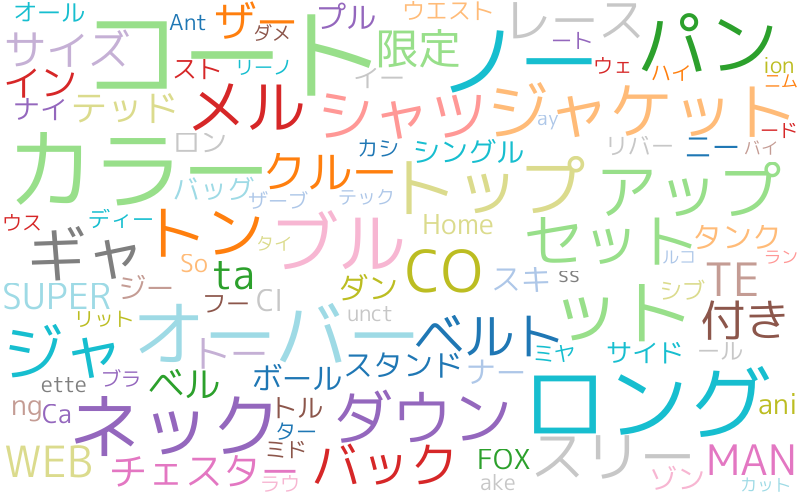

In [25]:
npt.wordcloud(
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
    stopwords=stopwords,
)

# [自然言語を簡単に可視化・分析できるライブラリ「nlplot」を公開しました](https://www.takapy.work/entry/2020/05/17/192947)

## N-gram bar chart

In [26]:
# 1. N-gram bar chart
npt.bar_ngram(title='uni-gram', ngram=1, top_n=50, stopwords=stopwords)

100%|██████████| 1000/1000 [00:00<00:00, 40917.64it/s]


In [27]:
npt.bar_ngram(title='bi-gram', ngram=2, top_n=50, stopwords=stopwords)

100%|██████████| 1000/1000 [00:00<00:00, 50363.28it/s]


## N-gram tree Map

In [28]:
# 2. N-gram tree Map
npt.treemap(title='Tree of Most Common Words', ngram=1, top_n=30, stopwords=stopwords)

100%|██████████| 1000/1000 [00:00<00:00, 49703.79it/s]


## Histogram of the word count

In [29]:
# 3. Histogram of the word count
npt.word_distribution(title='words distribution')

## wordcloud

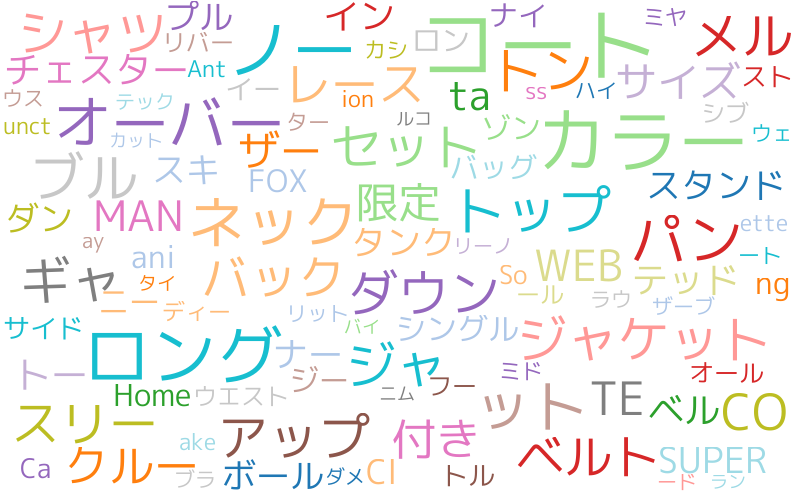

In [30]:
# 4. wordcloud
npt.wordcloud(stopwords=stopwords, colormap='tab20_r')

## co-occurrence networks

In [31]:
# 5. co-occurrence networks
npt.build_graph(stopwords=stopwords, min_edge_frequency=10)

# The number of nodes and edges to which this output is plotted.
# If this number is too large, plotting will take a long time, so adjust the [min_edge_frequency] well.
# >> node_size:70, edge_size:166
npt.co_network(title='Co-occurrence network')

node_size:210, edge_size:1273


## sunburst chart

In [32]:
# 6. sunburst chart
npt.sunburst(title='sunburst chart', colorscale=True)

## pyLDAvis

In [33]:
# 7. pyLDAvis
# If you want to run it in a notebook environment, you need to use the import and magic commands
import pyLDAvis
pyLDAvis.enable_notebook()
npt.ldavis(num_topics=5, passes=5, save=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.050542 -0.016368       1        1  41.404821
3     -0.060714  0.017343       2        1  32.102392
2     -0.073592 -0.078705       3        1  14.424285
0     -0.075914  0.076737       4        1  11.315803
4      0.260762  0.000993       5        1   0.752699, topic_info=     Term         Freq        Total Category  logprob  loglift
27     商品  2921.000000  2921.000000  Default  30.0000  30.0000
15      :  1947.000000  1947.000000  Default  29.0000  29.0000
16     ID  1948.000000  1948.000000  Default  28.0000  28.0000
22      の  1947.000000  1947.000000  Default  27.0000  27.0000
71     67   148.000000   148.000000  Default  26.0000  26.0000
..    ...          ...          ...      ...      ...      ...
23     ます     1.398906   974.340304   Topic5  -5.1618  -1.6568
28  問い合わせ     1.340620   974.354683   Topic5  -5.2044  -1.6994
25     下記     1.326229   974.647943   Topic5  -5.2152  -1.7105
20      お     1.292870   974.357657   Topic5  -5.2407  -1.7357
26      名     1.265847   974.430941   Topic5  -5.2618  -1.7569

[341 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.420703    ##-
0         2  0.334510    ##-
0         3  0.137498    ##-
0         4  0.105689    ##-
0         5  0.001026    ##-
...     ...       ...    ...
28        4  0.104685  問い合わせ
28        5  0.001026  問い合わせ
775       3  0.851385     西川
336       1  0.968753     限定
336       2  0.026183     限定

[482 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1, 5])